# Carbon dioxoide injection in aquifer
This example demonstrates a custom K-value compositional model for the
injection of CO2 into a saline aquifer. The physical model for flow of CO2 is
a realization of the description in [11th SPE Comparative Solutions
Project](https://spe.org/en/csp/). Simulation of CO2 can be challenging, and
we load the HYPRE package to improve performance.

The model also has an option to run immiscible simulations with otherwise
identical PVT behavior. This is often faster to run, but lacks the dissolution
model present in the compositional version (i.e. no solubility of CO2 in
brine, and no vaporization of water in the vapor phase).

In [4]:
import Pkg;Pkg.activate(".")

  Activating project at `C:\Users\D2A2\JutulDarcyRules_ME_Grant\src`


In [17]:
use_immiscible = false
using Jutul, JutulDarcy
using HYPRE
using GLMakie
nx = 128
nz = 128
Darcy, bar, kg, meter, day, yr = si_units(:darcy, :bar, :kilogram, :meter, :day, :year)

(9.86923266716013e-13, 100000.0, 1.0, 1.0, 86400.0, 3.1556952e7)

In [79]:
Darcy, bar, kg, meter, day = si_units(:darcy, :bar, :kilogram, :meter, :day)
nx = 128
ny = 1
nz = 128
cart_dims = (nx, ny, nz)
physical_dims = (1000.0, 1000.0, 100.0).*meter
g = CartesianMesh(cart_dims, physical_dims)
domain = reservoir_domain(g, permeability = 0.3Darcy, porosity = 0.2)
Injector = setup_vertical_well(domain, 1, 1, name = :Injector)
Producer = setup_well(domain, (nx, ny, 1), name = :Producer)
# Show the properties in the domain
domain

DataDomain wrapping CartesianMesh (3D) with 128x1x128=16384 cells with 17 data fields added:
  16384 Cells
    :permeability => 16384 Vector{Float64}
    :porosity => 16384 Vector{Float64}
    :rock_thermal_conductivity => 16384 Vector{Float64}
    :fluid_thermal_conductivity => 16384 Vector{Float64}
    :rock_density => 16384 Vector{Float64}
    :cell_centroids => 3×16384 Matrix{Float64}
    :volumes => 16384 Vector{Float64}
  32512 Faces
    :neighbors => 2×32512 Matrix{Int64}
    :areas => 32512 Vector{Float64}
    :normals => 3×32512 Matrix{Float64}
    :face_centroids => 3×32512 Matrix{Float64}
  65024 HalfFaces
    :half_face_cells => 65024 Vector{Int64}
    :half_face_faces => 65024 Vector{Int64}
  33280 BoundaryFaces
    :boundary_areas => 33280 Vector{Float64}
    :boundary_centroids => 3×33280 Matrix{Float64}
    :boundary_normals => 3×33280 Matrix{Float64}
    :boundary_neighbors => 33280 Vector{Int64}


In [81]:
domain[:permeability] = K_loaded

16384-element Vector{Float64}:
 4.2666150535032426e-18
 4.417504936037551e-18
 4.527732810796469e-18
 4.656143650107404e-18
 4.8090910363014975e-18
 4.8052628018842525e-18
 4.745407690391287e-18
 4.61519073328206e-18
 4.572388039322333e-18
 4.528811426183898e-18
 4.457229417016882e-18
 4.504942637356952e-18
 4.575737859330412e-18
 ⋮
 6.72149981977085e-13
 7.902623611175365e-13
 1.0306418470885765e-12
 1.0205876867829387e-12
 1.0649792350959168e-12
 1.1249716886025784e-12
 1.1778964125724773e-12
 1.1833111179219098e-12
 1.2168030191756108e-12
 1.257387588090612e-12
 1.2802174170753148e-12
 1.2853716575684679e-12

In [82]:
phases = (LiquidPhase(), VaporPhase())
rhoLS = 1000.0kg/meter^3
rhoGS = 100.0kg/meter^3
reference_densities = [rhoLS, rhoGS]
sys = ImmiscibleSystem(phases, reference_densities = reference_densities)

ImmiscibleSystem with LiquidPhase, VaporPhase

In [83]:
model, parameters = setup_reservoir_model(domain, sys, wells = [Injector, Producer])
model

MultiModel with 4 models and 6 cross-terms. 33161 equations, 33161 degrees of freedom and 114827 parameters.

  models:
    1) Reservoir (32768x32768)
       ImmiscibleSystem with LiquidPhase, VaporPhase
       ∈ MinimalTPFATopology (16384 cells, 32512 faces)
    2) Injector (386x386)
       ImmiscibleSystem with LiquidPhase, VaporPhase
       ∈ MultiSegmentWell [Injector] (129 nodes, 128 segments, 128 perforations)
    3) Producer (5x5)
       ImmiscibleSystem with LiquidPhase, VaporPhase
       ∈ MultiSegmentWell [Producer] (2 nodes, 1 segments, 1 perforations)
    4) Facility (2x2)
       JutulDarcy.PredictionMode()
       ∈ WellGroup([:Injector, :Producer], true, true)

  cross_terms:
    1) Injector <-> Reservoir (Eq: mass_conservation)
       JutulDarcy.ReservoirFromWellFlowCT
    2) Producer <-> Reservoir (Eq: mass_conservation)
       JutulDarcy.ReservoirFromWellFlowCT
    3) Injector  -> Facility (Eq: control_equation)
       JutulDarcy.FacilityFromWellFlowCT
    4) Facility  

In [100]:
rmodel = reservoir_model(model)

SimulationModel:

  Model with 32768 degrees of freedom, 32768 equations and 114176 parameters

  domain:
    DiscretizedDomain with MinimalTPFATopology (16384 cells, 32512 faces) and discretizations for mass_flow, heat_flow

  system:
    ImmiscibleSystem with LiquidPhase, VaporPhase

  context:
    DefaultContext(BlockMajorLayout(false), 1000, 1)

  formulation:
    FullyImplicitFormulation()

  data_domain:
    DataDomain wrapping CartesianMesh (3D) with 128x1x128=16384 cells with 17 data fields added:
  16384 Cells
    :permeability => 16384 Vector{Float64}
    :porosity => 16384 Vector{Float64}
    :rock_thermal_conductivity => 16384 Vector{Float64}
    :fluid_thermal_conductivity => 16384 Vector{Float64}
    :rock_density => 16384 Vector{Float64}
    :cell_centroids => 3×16384 Matrix{Float64}
    :volumes => 16384 Vector{Float64}
  32512 Faces
    :neighbors => 2×32512 Matrix{Int64}
    :areas => 32512 Vector{Float64}
    :normals => 3×32512 Matrix{Float64}
    :face_centroids =>

In [85]:
state0 = setup_reservoir_state(model,
    Pressure = 120bar,
    Saturations = [1.0, 0.0]
)

Dict{Any, Any} with 4 entries:
  :Producer  => Dict{Symbol, Any}(:TotalMassFlux=>[0.0], :PhaseMassDensities=>[…
  :Injector  => Dict{Symbol, Any}(:TotalMassFlux=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0…
  :Reservoir => Dict{Symbol, Any}(:PhaseMassMobilities=>[0.0 0.0 … 0.0 0.0; 0.0…
  :Facility  => Dict{Symbol, Any}(:TotalSurfaceMassRate=>[0.0, 0.0], :WellGroup…

In [123]:
nstep = 25
dt = fill(365.0day, nstep);
total_time = sum(dt)

7.884e8

In [124]:
pv = pore_volume(model, parameters)
inj_rate = 1.5*sum(pv)/total_time
rate_target = TotalRateTarget(inj_rate)

TotalRateTarget with value 0.0380517503805175 [m^3/s]

In [88]:
bhp_target = BottomHolePressureTarget(100bar)

BottomHolePressureTarget with value 100.0 [bar]

In [89]:
I_ctrl = InjectorControl(rate_target, [0.0, 1.0], density = rhoGS)
P_ctrl = ProducerControl(bhp_target)
controls = Dict(:Injector => I_ctrl, :Producer => P_ctrl)
forces = setup_reservoir_forces(model, control = controls);

In [108]:
case = JutulCase(model, dt, forces, parameters = parameters, state0 = state0)

Jutul case with 25 time-steps (24 years, 51 weeks, 2.18 days) and constant forces for all steps.

Model:

MultiModel with 4 models and 6 cross-terms. 33161 equations, 33161 degrees of freedom and 114827 parameters.

  models:
    1) Reservoir (32768x32768)
       ImmiscibleSystem with LiquidPhase, VaporPhase
       ∈ MinimalTPFATopology (16384 cells, 32512 faces)
    2) Injector (386x386)
       ImmiscibleSystem with LiquidPhase, VaporPhase
       ∈ MultiSegmentWell [Injector] (129 nodes, 128 segments, 128 perforations)
    3) Producer (5x5)
       ImmiscibleSystem with LiquidPhase, VaporPhase
       ∈ MultiSegmentWell [Producer] (2 nodes, 1 segments, 1 perforations)
    4) Facility (2x2)
       JutulDarcy.PredictionMode()
       ∈ WellGroup([:Injector, :Producer], true, true)

  cross_terms:
    1) Injector <-> Reservoir (Eq: mass_conservation)
       JutulDarcy.ReservoirFromWellFlowCT
    2) Producer <-> Reservoir (Eq: mass_conservation)
       JutulDarcy.ReservoirFromWellFlowCT
    

In [150]:
result = simulate_reservoir(state0, model, dt, parameters = parameters, forces = forces, info_level=1)
wd, states, t = result

Jutul: Simulating 24 years, 51.31 weeks as 25 report steps
Step  1/25: Solving start to 52 weeks, 1 day, Δt = 52 weeks, 1 day 
Step  2/25: Solving 52 weeks, 1 day to 1 year, 52.11 weeks, Δt = 52 weeks, 1 day 
Step  3/25: Solving 1 year, 52.11 weeks to 2 years, 52.07 weeks, Δt = 52 weeks, 1 day 
Step  4/25: Solving 2 years, 52.07 weeks to 3 years, 52.04 weeks, Δt = 52 weeks, 1 day 
Step  5/25: Solving 3 years, 52.04 weeks to 4 years, 52 weeks, Δt = 52 weeks, 1 day 
Step  6/25: Solving 4 years, 52 weeks to 5 years, 51.97 weeks, Δt = 52 weeks, 1 day 
Step  7/25: Solving 5 years, 51.97 weeks to 6 years, 51.94 weeks, Δt = 52 weeks, 1 day 
Step  8/25: Solving 6 years, 51.94 weeks to 7 years, 51.9 weeks, Δt = 52 weeks, 1 day 
Step  9/25: Solving 7 years, 51.9 weeks to 8 years, 51.87 weeks, Δt = 52 weeks, 1 day 
Step 10/25: Solving 8 years, 51.87 weeks to 9 years, 51.83 weeks, Δt = 52 weeks, 1 day 
Step 11/25: Solving 9 years, 51.83 weeks to 10 years, 51.8 weeks, Δt = 52 weeks, 1 day 
Step 12/

ReservoirSimResult with 25 entries:

  wells (2 present):
    :Producer
    :Injector
    Results per well:
       :Vapor_mass_rate => Vector{Float64} of size (25,)
       :lrat => Vector{Float64} of size (25,)
       :orat => Vector{Float64} of size (25,)
       :control => Vector{Symbol} of size (25,)
       :bhp => Vector{Float64} of size (25,)
       :Liquid_mass_rate => Vector{Float64} of size (25,)
       :mass_rate => Vector{Float64} of size (25,)
       :rate => Vector{Float64} of size (25,)
       :grat => Vector{Float64} of size (25,)
       :gor => Vector{Float64} of size (25,)

  states (Vector with 25 entries, reservoir variables for each state)
    :Saturations => Matrix{Float64} of size (2, 16384)
    :Pressure => Vector{Float64} of size (16384,)
    :TotalMasses => Matrix{Float64} of size (2, 16384)

  time (report time for each state)
     Vector{Float64} of length 25

  result (extended states, reports)
     SimResult with 25 entries

  extra
     Dict{Any, Any} with 

In [152]:
function set_perm(K):
    domain[:permeabiltiy] = K
    return domain
end

model, parameters = setup_reservoir_model(set_perm(x), sys, wells = [Injector, Producer])
state(x) = simulate_reservoir(x, model, dt, parameters = parameters, forces = forces, info_level=1)
wd, states, t = result

state_sat(x) = Saturations(state(x)[:state])
cur_sample = Saturations(state_K[:state])

noise = rand(dist, size(cur_sample))
print("noise", size(noise))

# 2-1. compute log likelihood
# ll(x) = norm(vec(cur_sample+noise) - state_sat(x))^2 / (2 * σ^2) 
ll(x) = norm(state_sat(x))^2 / (2 * σ^2) 
print("computing gradient... ", size(vec(K)))
# 2-2. compute gradient
Profile.clear()
@time outer_vector = Zygote.gradient((x)->ll(x), vec(K))[1]

Jutul: Simulating 24 years, 51.31 weeks as 25 report steps
Step  1/25: Solving start to 52 weeks, 1 day, Δt = 52 weeks, 1 day 
Step  2/25: Solving 52 weeks, 1 day to 1 year, 52.11 weeks, Δt = 52 weeks, 1 day 
Step  3/25: Solving 1 year, 52.11 weeks to 2 years, 52.07 weeks, Δt = 52 weeks, 1 day 
[34

LoadError: InterruptException:

In [153]:
function objective_function(model, state, Δt, step_i, forces)
    grat = JutulDarcy.compute_well_qoi(model, state, forces, :Producer, SurfaceGasRateTarget)
    return Δt*grat/(inj_rate*total_time)
end
@time data_domain_with_gradients = JutulDarcy.reservoir_sensitivities(case, result, objective_function)

  3.805791 seconds (47.87 M allocations: 1.746 GiB, 15.19% gc time, 8.54% compilation time: 90% of which was recompilation)


DataDomain wrapping CartesianMesh (3D) with 128x1x128=16384 cells with 17 data fields added:
  16384 Cells
    :permeability => 16384 Vector{Float64}
    :porosity => 16384 Vector{Float64}
    :rock_thermal_conductivity => 16384 Vector{Float64}
    :fluid_thermal_conductivity => 16384 Vector{Float64}
    :rock_density => 16384 Vector{Float64}
    :cell_centroids => 3×16384 Matrix{Float64}
    :volumes => 16384 Vector{Float64}
  32512 Faces
    :neighbors => 2×32512 Matrix{Int64}
    :areas => 32512 Vector{Float64}
    :normals => 3×32512 Matrix{Float64}
    :face_centroids => 3×32512 Matrix{Float64}
  65024 HalfFaces
    :half_face_cells => 65024 Vector{Int64}
    :half_face_faces => 65024 Vector{Int64}
  33280 BoundaryFaces
    :boundary_areas => 33280 Vector{Float64}
    :boundary_centroids => 3×33280 Matrix{Float64}
    :boundary_normals => 3×33280 Matrix{Float64}
    :boundary_neighbors => 33280 Vector{Int64}


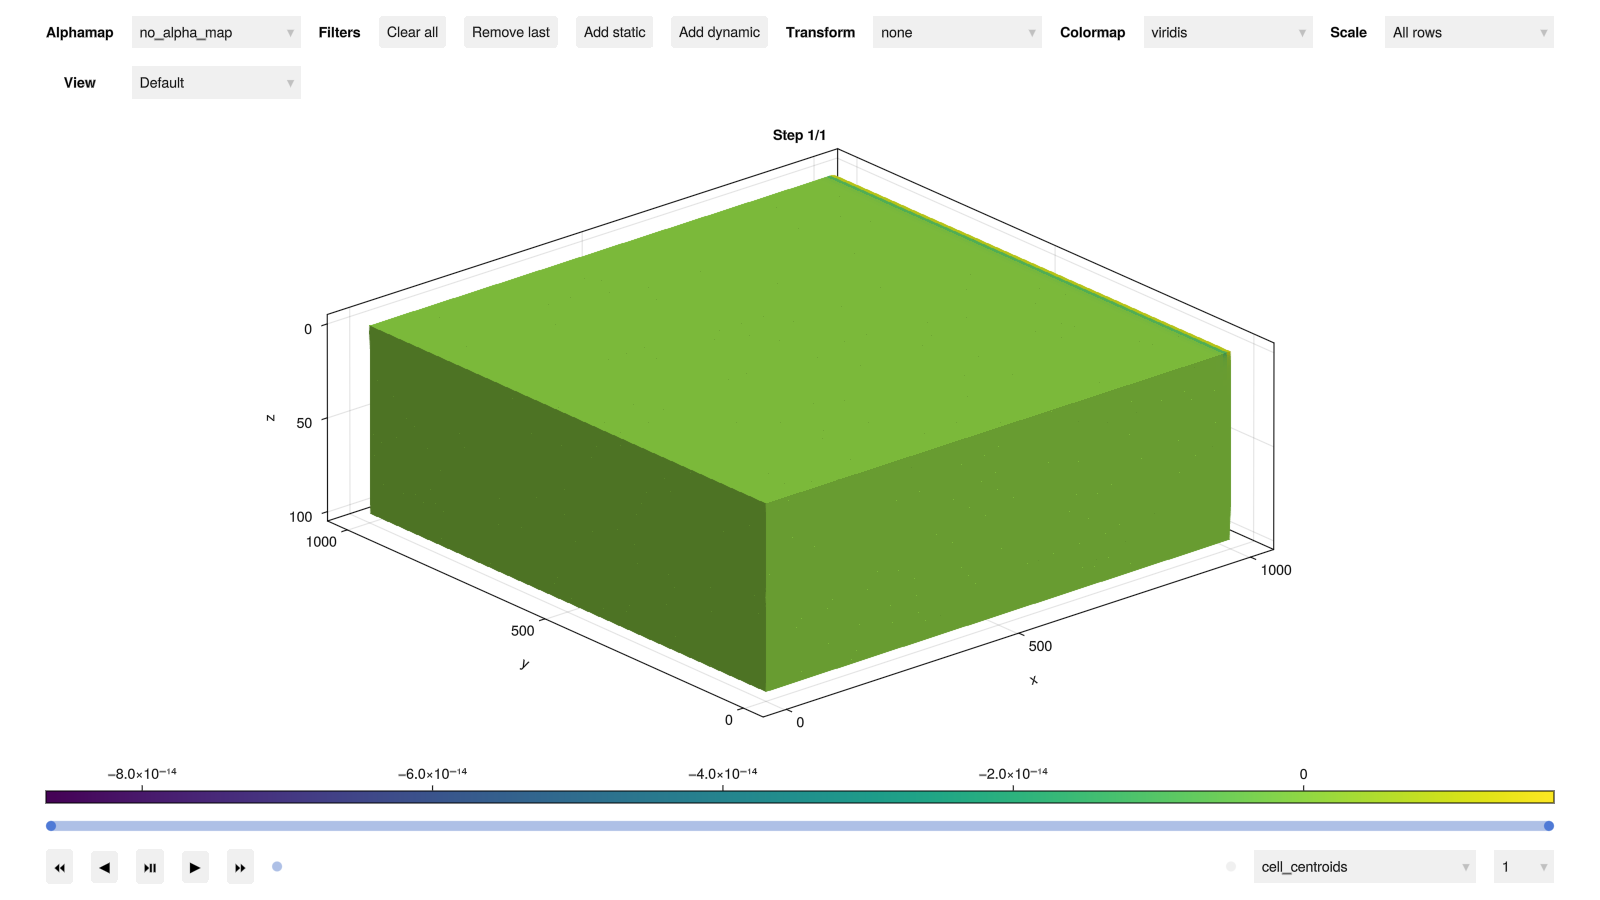

In [127]:
plot_reservoir(data_domain_with_gradients)

In [135]:
∂K = data_domain_with_gradients[:permeability]
∂ϕ = data_domain_with_gradients[:porosity]
big = false 

function get_cscale(x)
    minv0, maxv0 = extrema(x)
    minv = min(minv0, -maxv0)
    maxv = max(maxv0, -minv0)
    return (minv, maxv)
end

function myplot(title, vals; kwarg...)
    fig = Figure()
    myplot!(fig, 1, 1, title, vals; kwarg...)
    return fig
end

function myplot!(fig, I, J, title, vals; is_grad = false, is_log = false, colorrange = missing, contourplot = false, nticks = 5, ticks = missing, colorbar = true, kwarg...)
    ax = Axis(fig[I, J], title = title)

    if is_grad
        if ismissing(colorrange)
            colorrange = get_cscale(vals)
        end
        cmap = :seismic
    else
        if ismissing(colorrange)
            colorrange = extrema(vals)
        end
        cmap = :seaborn_icefire_gradient
    end
    hidedecorations!(ax)
    hidespines!(ax)
    arg = (; colormap = cmap, colorrange = colorrange, kwarg...)
    plt = plot_cell_data!(ax, g, vals; shading = NoShading, arg...)
    if colorbar
        if ismissing(ticks)
            ticks = range(colorrange..., nticks)
        end
        Colorbar(fig[I, J+1], plt, ticks = ticks, ticklabelsize = 25, size = 25)
    end
    return fig
end

LoadError: cannot assign a value to imported variable Base.big from module Main

In [140]:
∂K

16384-element Vector{Float64}:
 -0.0019121112091458304
 -0.003020470748773988
 -0.0018880550775271223
 -0.0010501818000810976
 -0.0005384814636447367
 -0.00027480789258830553
 -0.00013610270485712536
 -6.891945680325346e-5
 -3.649267503966658e-5
 -2.206480918274495e-5
 -1.571326351382753e-5
 -1.1345947050580113e-5
 -7.184320681555752e-6
  ⋮
 -7.855371025470141e-10
 -7.385311540816211e-10
 -5.204079005340264e-10
 -5.22629339564559e-10
 -4.4078247583728666e-10
 -3.7399468814948233e-10
 -3.0626513709755127e-10
 -2.525327007148532e-10
 -1.8697822110643714e-10
 -1.1577853538938636e-10
 -4.828812658666389e-11
 -9.662408825816276e-12

In [ ]:
state_sat(x) = Saturations(state(x)[:state])
cur_sample = Saturations(state_K[:state])

noise = rand(dist, size(cur_sample))
print("noise", size(noise))

# 2-1. compute log likelihood
ll(x) = norm(vec(cur_sample+noise) - state_sat(x))^2 / (2 * σ^2) 
print("computing gradient... ", size(vec(K)))
# 2-2. compute gradient
Profile.clear()
@time outer_vector = Zygote.gradient((x)->ll(x), vec(K))[1]

In [143]:
using PyPlot

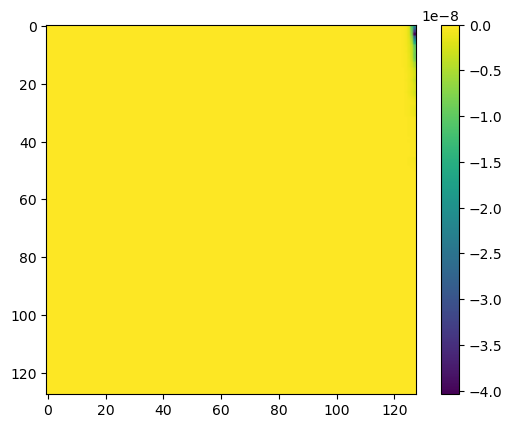

PyObject <matplotlib.colorbar.Colorbar object at 0x000001FC7F40A2A0>

In [148]:

# cr = (-0.05, 0.05)
# cticks = [-0.05, -0.025, 0, 0.025, 0.05]

gradient = ∂K.*Darcy
imshow(reshape(gradient, nx, nz)')
colorbar()

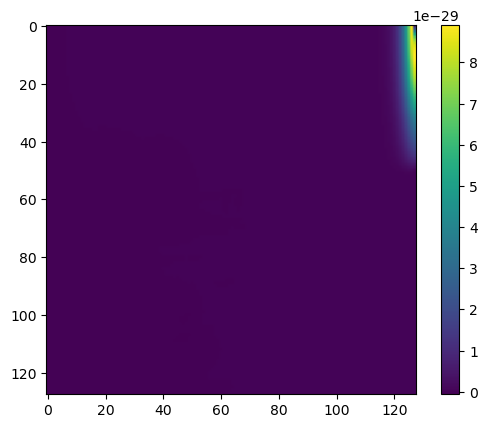

PyObject <matplotlib.colorbar.Colorbar object at 0x000001FC7F1885C0>

In [149]:
gradient = ∂ϕ.*Darcy
imshow(reshape(gradient, nx, nz)')
colorbar()

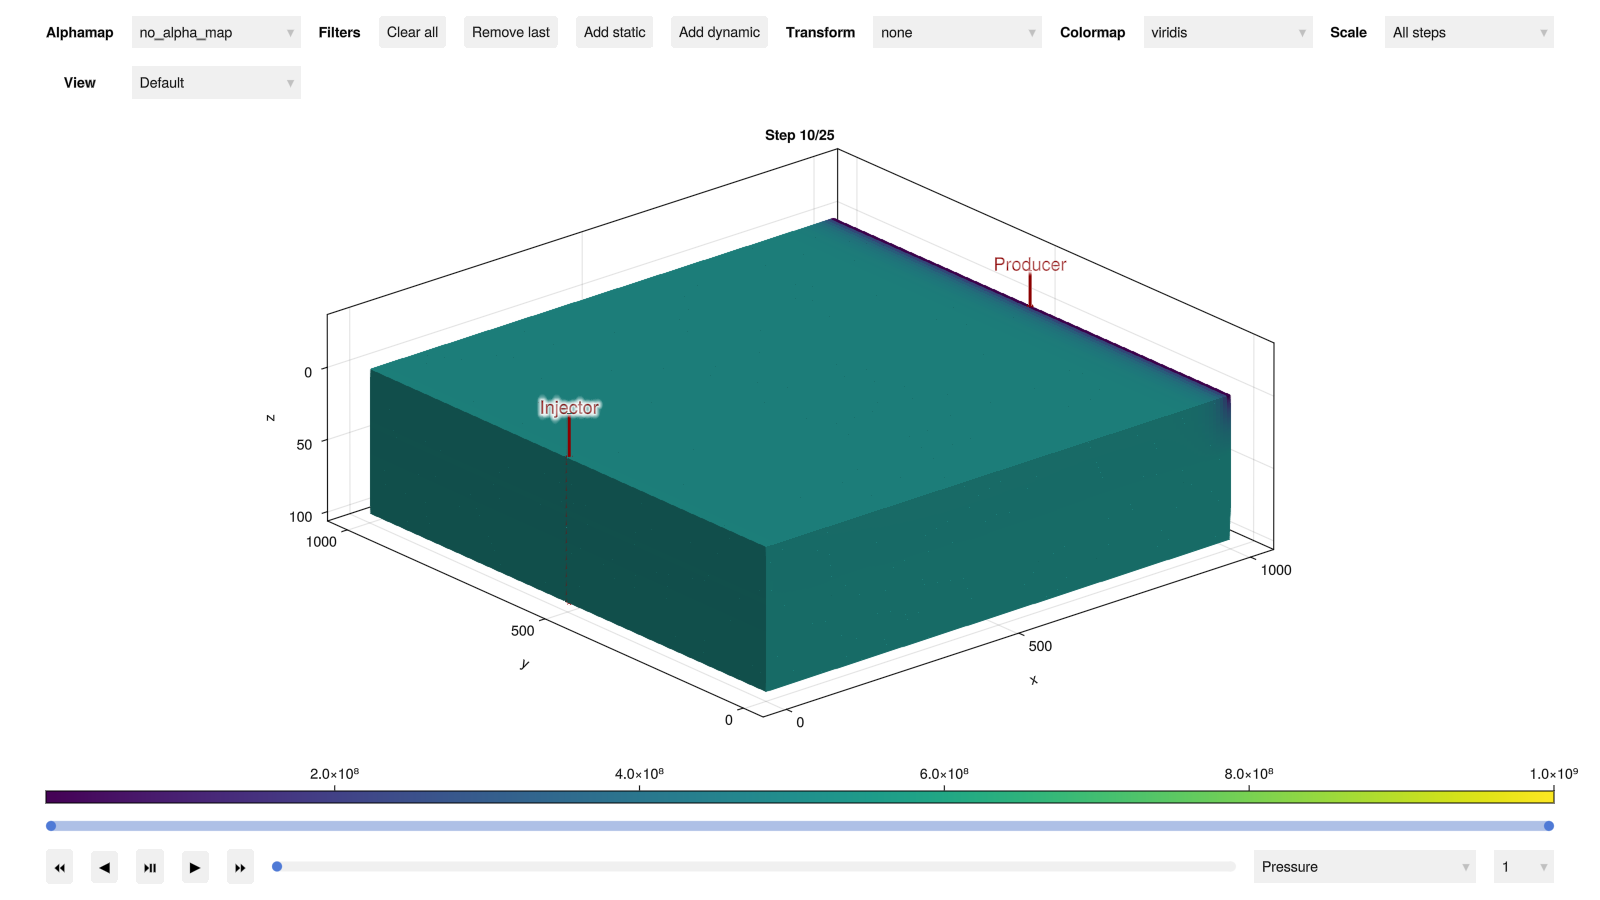

In [99]:
plot_reservoir(model, states, key = :Pressure, step = 10)

In [91]:
wd(:Producer)

Legend
┌──────────────────┬──────────────────────────────────────────┬──────┬────────────────────────────────┐
│ Label            │ Description                              │ Unit │ Type of quantity               │
├──────────────────┼──────────────────────────────────────────┼──────┼────────────────────────────────┤
│ Liquid_mass_rate │ Component mass rate for Liquid component │ kg/s │ mass per time                  │
│ Vapor_mass_rate  │ Component mass rate for Vapor component  │ kg/s │ mass per time                  │
│ bhp              │ Bottom hole pressure                     │ Pa   │ pressure                       │
│ control          │ Control                                  │ -    │ none                           │
│ gor              │ Gas-oil-ratio                            │      │ id                             │
│ grat             │ Surface gas rate                         │ m³/s │ gas_volume_surface per time    │
│ lrat             │ Surface water rate                  

In [92]:
wd(:Injector, :bhp)

Legend
┌───────┬──────────────────────┬──────┬──────────────────┐
│ Label │ Description          │ Unit │ Type of quantity │
├───────┼──────────────────────┼──────┼──────────────────┤
│ bhp   │ Bottom hole pressure │ Pa   │ pressure         │
└───────┴──────────────────────┴──────┴──────────────────┘
Injector result
┌────────┬───────────┐
│   time │       bhp │
│   days │        Pa │
├────────┼───────────┤
│  365.0 │ 7.23621e7 │
│  730.0 │ 1.29003e8 │
│ 1095.0 │ 1.83625e8 │
│ 1460.0 │ 2.36164e8 │
│ 1825.0 │ 2.86844e8 │
│ 2190.0 │ 3.35767e8 │
│ 2555.0 │ 3.82903e8 │
│ 2920.0 │ 4.28369e8 │
│ 3285.0 │ 4.72242e8 │
│ 3650.0 │ 5.14575e8 │
│ 4015.0 │ 5.55462e8 │
│ 4380.0 │ 5.94889e8 │
│ 4745.0 │ 6.32863e8 │
│ 5110.0 │  6.6953e8 │
│ 5475.0 │ 7.04937e8 │
│ 5840.0 │ 7.39132e8 │
│ 6205.0 │ 7.72161e8 │
│ 6570.0 │ 8.04065e8 │
│ 6935.0 │ 8.34888e8 │
│ 7300.0 │ 8.64667e8 │
│ 7665.0 │ 8.93442e8 │
│ 8030.0 │ 9.21248e8 │
│ 8395.0 │ 9.48121e8 │
│ 8760.0 │ 9.74093e8 │
│ 9125.0 │ 9.99198e8 │
└────────┴─────

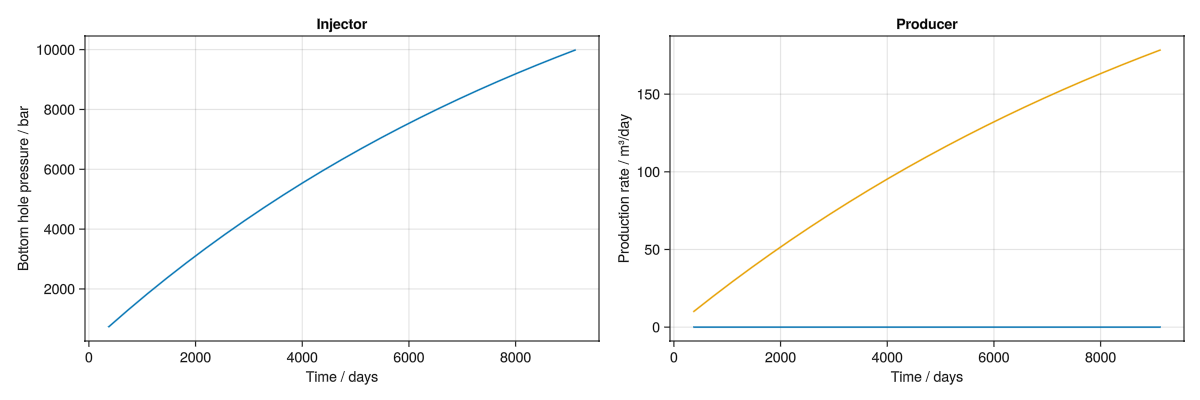

In [93]:
using GLMakie
grat = wd[:Producer, :grat]
lrat = wd[:Producer, :lrat]
bhp = wd[:Injector, :bhp]
fig = Figure(size = (1200, 400))
ax = Axis(fig[1, 1],
    title = "Injector",
    xlabel = "Time / days",
    ylabel = "Bottom hole pressure / bar")
lines!(ax, t/day, bhp./bar)
ax = Axis(fig[1, 2],
    title = "Producer",
    xlabel = "Time / days",
    ylabel = "Production rate / m³/day")
lines!(ax, t/day, abs.(grat).*day)
lines!(ax, t/day, abs.(lrat).*day)
fig

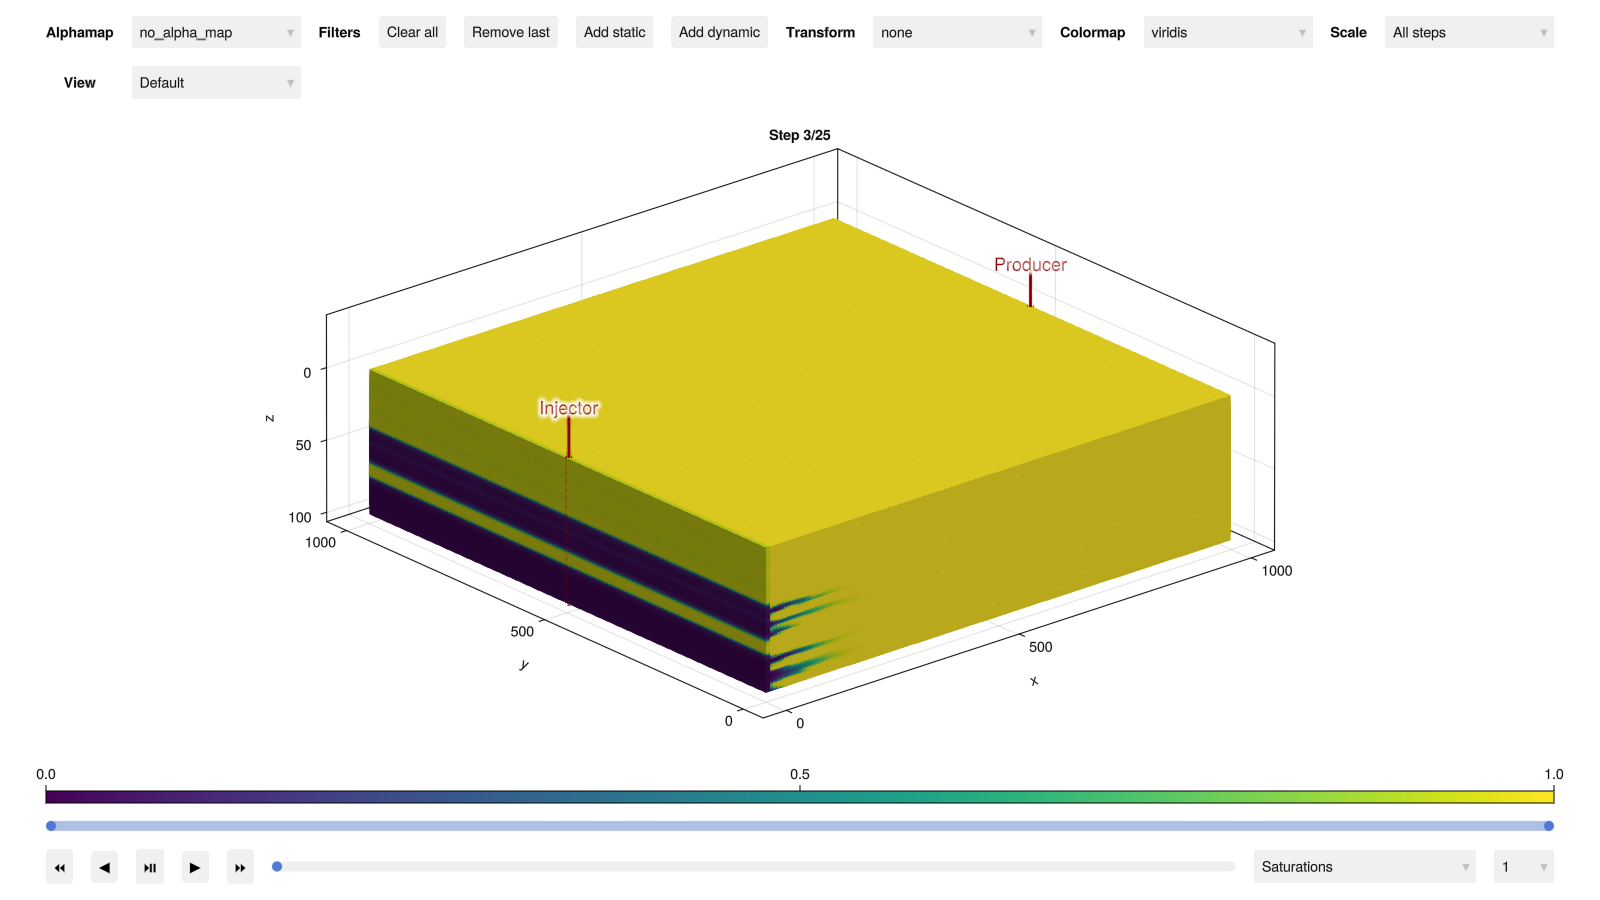

In [94]:
plot_reservoir(model, states, key = :Saturations, step = 3)

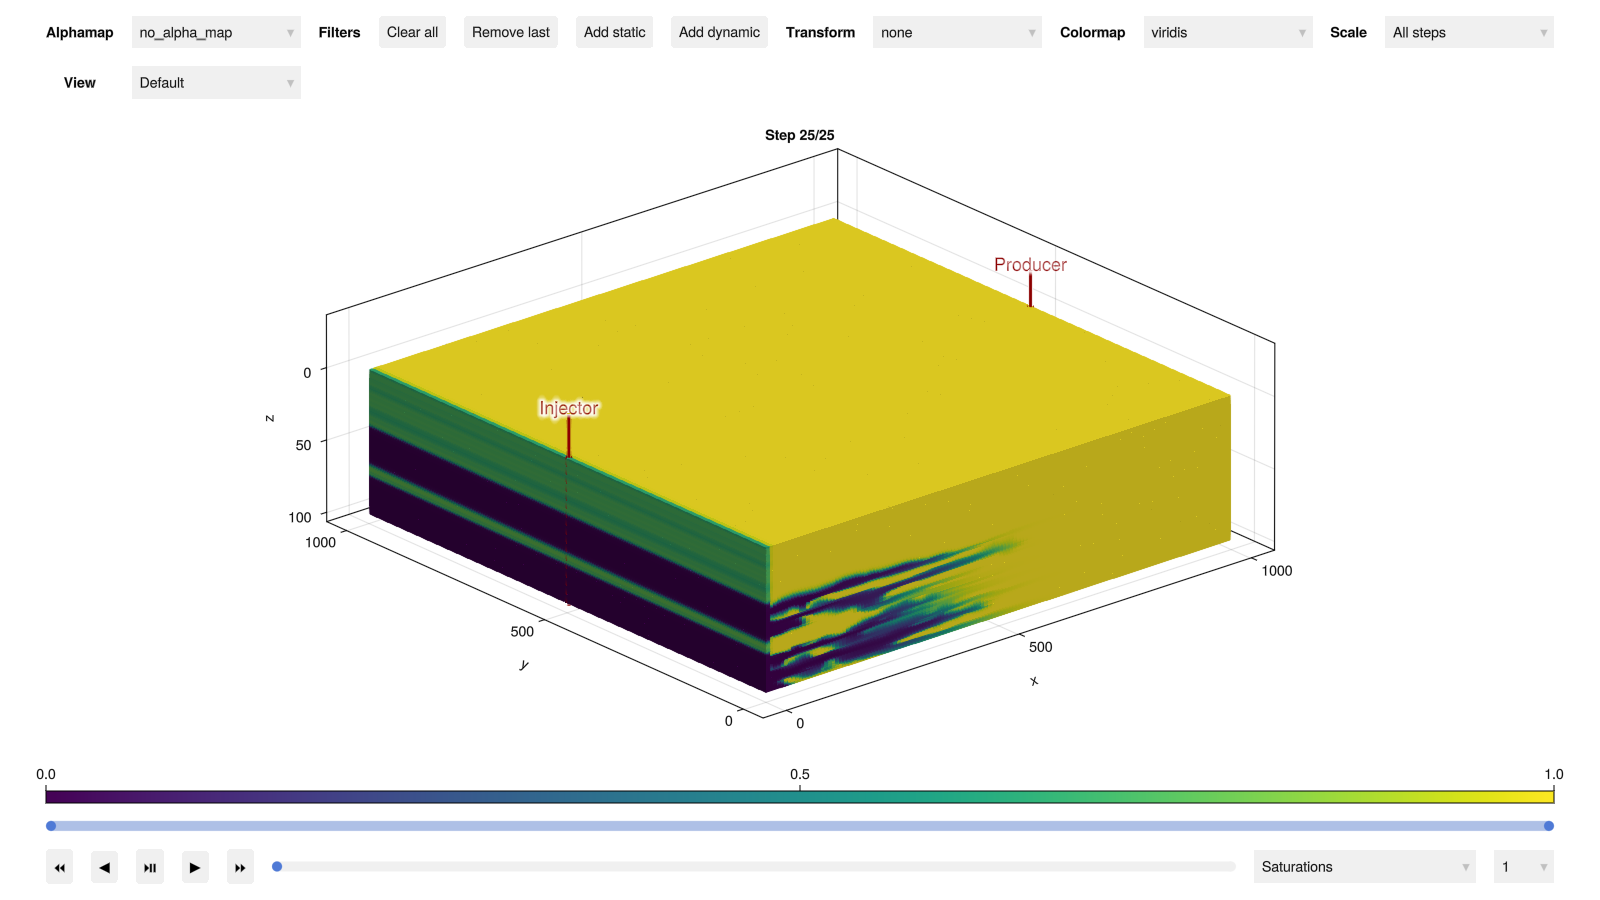

In [95]:
plot_reservoir(model, states, key = :Saturations, step = 25)

[ Info: Precompiling GraphMakie [1ecd5474-83a3-4783-bb4f-06765db800d2]
[ Info: Precompiling JutulGraphMakieExt [ee07502e-749b-517d-b00f-a1bb5b2b822b]


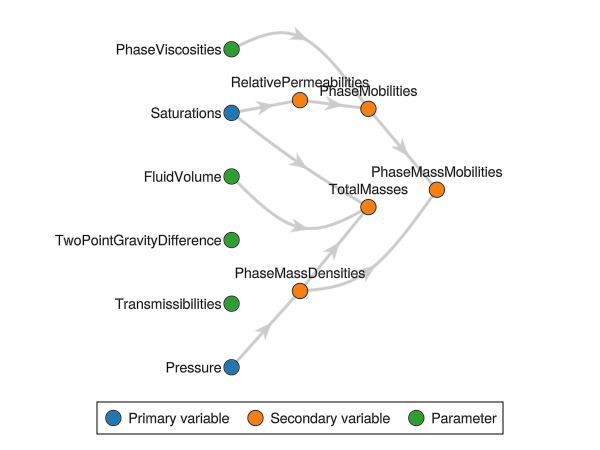

In [107]:
using NetworkLayout, LayeredLayouts, GraphMakie
Jutul.plot_variable_graph(rmodel)

## Set up a 2D aquifer model
We set up a Cartesian mesh that is then transformed into an unstructured mesh.
We can then modify the coordinates to create a domain with a undulating top
surface. CO2 will flow along the top surface and the topography of the top
surface has a large impact on where the CO2 migrates.

In [18]:
cart_dims = (nx, 1, nz)
physical_dims = (1000.0, 1.0, 50.0)
cart_mesh = CartesianMesh(cart_dims, physical_dims)
# mesh = UnstructuredMesh(cart_mesh, z_is_depth = true)

# points = mesh.node_points
# for (i, pt) in enumerate(points)
#     x, y, z = pt
#     x_u = 2*π*x/1000.0
#     w = 0.2
#     dz = 0.05*x + 0.05*abs(x - 500.0)+ w*(30*sin(2.0*x_u) + 20*sin(5.0*x_u))
#     points[i] = pt + [0, 0, dz]
# end;

CartesianMesh (3D) with 128x1x128=16384 cells

## Find and plot cells intersected by a deviated injector well
We place a single injector well. This well was unfortunately not drilled
completely straight, so we cannot directly use `add_vertical_well` based on
logical indices. We instead define a matrix with three columns x, y, z that
lie on the well trajectory and use utilities from `Jutul` to find the cells
intersected by the trajectory.

In [75]:
import Jutul: find_enclosing_cells, plot_mesh_edges
trajectory = [
    105.0 0.5 64;    # First point
    # 66.0 0.5 115;    # Second point
    # 71.0 0.5 130.0  # Third point
]
wc = find_enclosing_cells(cart_mesh, trajectory)

fig, ax, plt = plot_mesh_edges(cart_mesh)
plot_mesh!(ax, cart_mesh, cells = wc, transparency = true, alpha = 0.4)

View from the side

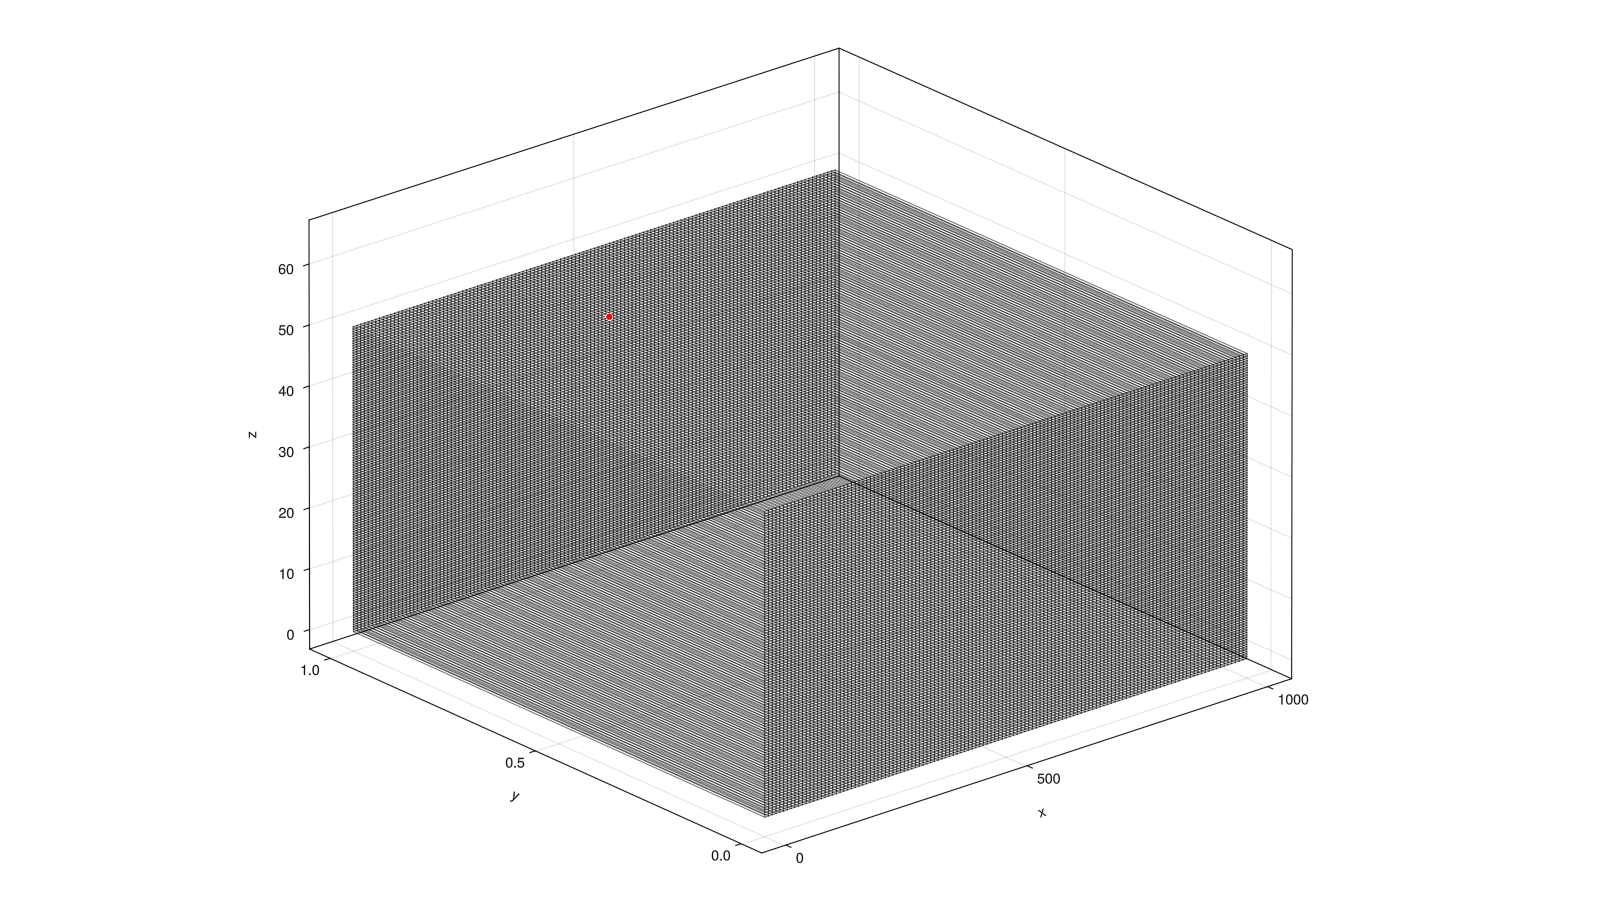

In [76]:
# ax.azimuth[] = 1.5*π
# ax.elevation[] = 0.0
scatter!(ax, trajectory', color = :red)
fig

## Define permeability and porosity
We loop over all cells and define three layered regions by the K index of each
cell. We can then set a corresponding diagonal permeability tensor (3 values)
and porosity (scalar) to introduce variation between the layers.

In [45]:
using JLD2
@load "K_sample.jld2" slice
K_loaded = reshape(slice, nx*nz)

16384-element Vector{Float64}:
 4.2666150535032426e-18
 4.417504936037551e-18
 4.527732810796469e-18
 4.656143650107404e-18
 4.8090910363014975e-18
 4.8052628018842525e-18
 4.745407690391287e-18
 4.61519073328206e-18
 4.572388039322333e-18
 4.528811426183898e-18
 4.457229417016882e-18
 4.504942637356952e-18
 4.575737859330412e-18
 ⋮
 6.72149981977085e-13
 7.902623611175365e-13
 1.0306418470885765e-12
 1.0205876867829387e-12
 1.0649792350959168e-12
 1.1249716886025784e-12
 1.1778964125724773e-12
 1.1833111179219098e-12
 1.2168030191756108e-12
 1.257387588090612e-12
 1.2802174170753148e-12
 1.2853716575684679e-12

In [28]:
nc = number_of_cells(cart_mesh)

16384

In [44]:
size(perm[1, :]), size(K)

((16384,), (16384,))

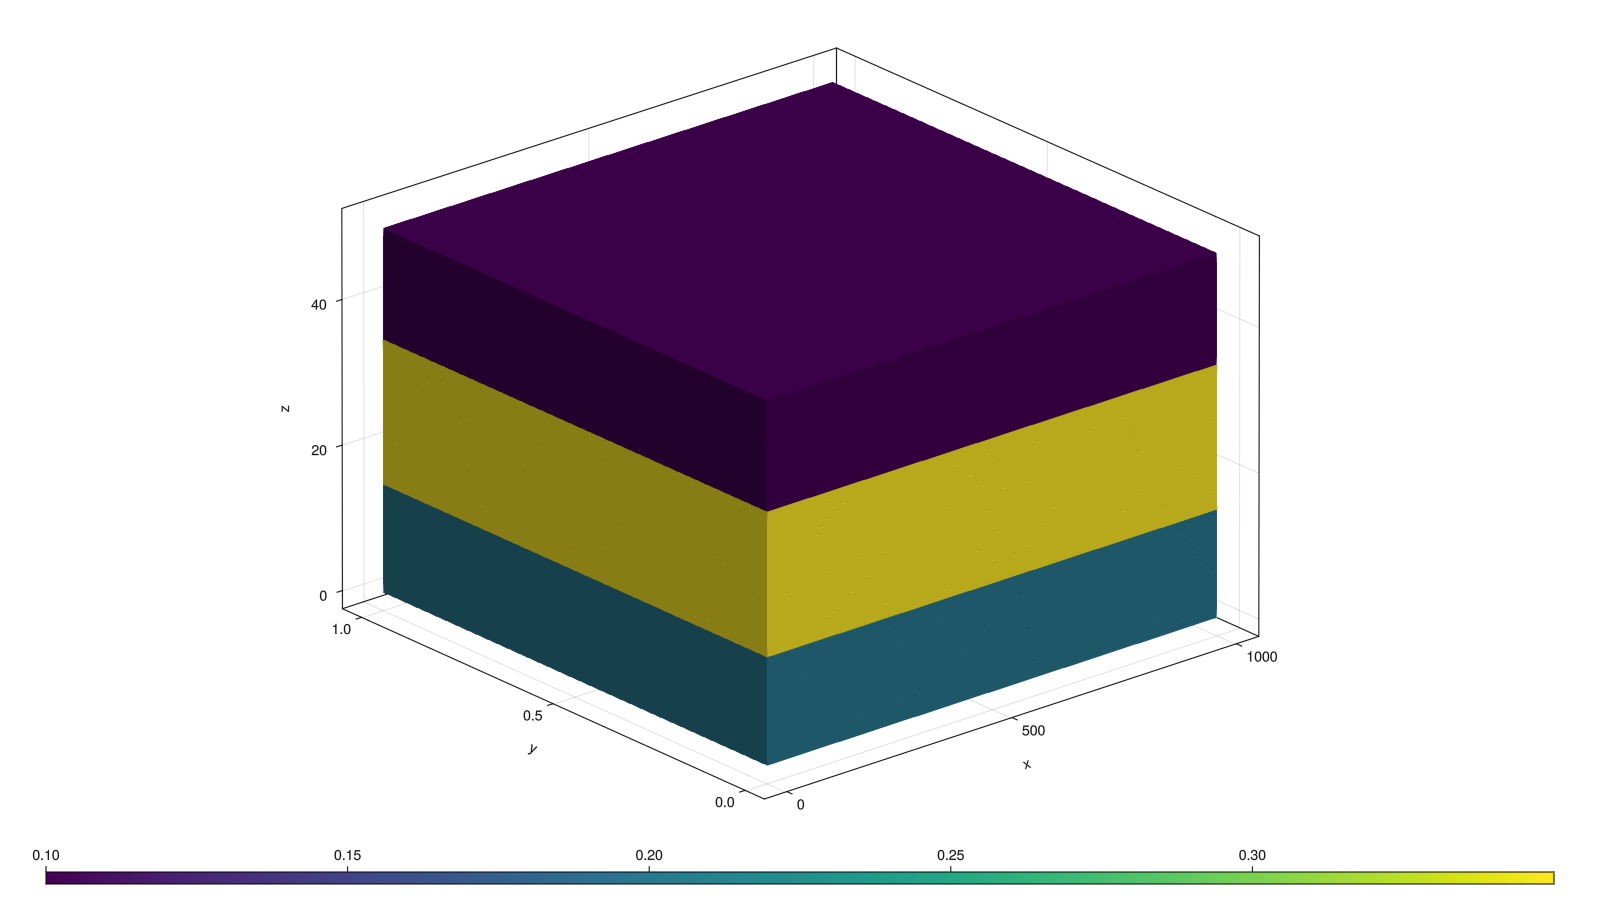

In [46]:
poro = fill(0.5, nc)
region = zeros(Int, nc)
for cell in 1:nc
    I, J, K = cell_ijk(cart_mesh, cell)
    if K < 0.3*nz
        reg = 1
        permxy = 0.3*Darcy
        phi = 0.2
    elseif K < 0.7*nz
        reg = 2
        permxy = 1.2*Darcy
        phi = 0.35
    else
        reg = 3
        permxy = 0.1*Darcy
        phi = 0.1
    end
    permz = 0.5*permxy
    perm[1, cell] = perm[2, cell] = permxy
    perm[3, cell] = permz
    poro[cell] = phi
    region[cell] = reg
end

perm[1, :] = K_loaded
perm[2, :] = K_loaded
perm[3, :] = K_loaded

fig, ax, plt = plot_cell_data(cart_mesh, poro)
fig

## Set up simulation model
We set up a domain and a single injector. We pass the special :co2brine
argument in place of the system to the reservoir model setup routine. This
will automatically set up a compositional two-component CO2-H2O model with the
appropriate functions for density, viscosity and miscibility.

Note that this model by default is isothermal, but we still need to specify a
temperature when setting up the model. This is because the properties of CO2
strongly depend on temperature, even when thermal transport is not solved.

The model also accounts for a constant, reservoir-wide salinity. We input mole
fractions of salts in the brine so that the solubilities, densities and
viscosities for brine cells are corrected in the property model.

In [77]:
domain = reservoir_domain(cart_mesh, permeability = perm, porosity = poro, temperature = convert_to_si(60.0, :Celsius))

DataDomain wrapping CartesianMesh (3D) with 128x1x128=16384 cells with 18 data fields added:
  16384 Cells
    :permeability => 3×16384 Matrix{Float64}
    :porosity => 16384 Vector{Float64}
    :rock_thermal_conductivity => 16384 Vector{Float64}
    :fluid_thermal_conductivity => 16384 Vector{Float64}
    :rock_density => 16384 Vector{Float64}
    :temperature => 16384 Vector{Float64}
    :cell_centroids => 3×16384 Matrix{Float64}
    :volumes => 16384 Vector{Float64}
  32512 Faces
    :neighbors => 2×32512 Matrix{Int64}
    :areas => 32512 Vector{Float64}
    :normals => 3×32512 Matrix{Float64}
    :face_centroids => 3×32512 Matrix{Float64}
  65024 HalfFaces
    :half_face_cells => 65024 Vector{Int64}
    :half_face_faces => 65024 Vector{Int64}
  33280 BoundaryFaces
    :boundary_areas => 33280 Vector{Float64}
    :boundary_centroids => 3×33280 Matrix{Float64}
    :boundary_normals => 3×33280 Matrix{Float64}
    :boundary_neighbors => 33280 Vector{Int64}


In [78]:
Injector = setup_well(domain, wc, name = :Injector, simple_well = true)

LoadError: BoundsError: attempt to access 3×0 Matrix{Float64} at index [3, 1]

In [65]:
if use_immiscible
    physics = :immiscible
else
    physics = :kvalue
end
model = setup_reservoir_model(domain, :co2brine,
    wells = Injector,
    extra_out = false,
    salt_names = ["NaCl", "KCl", "CaSO4", "CaCl2", "MgSO4", "MgCl2"],
    salt_mole_fractions = [0.01, 0.005, 0.005, 0.001, 0.0002, 1e-5],
    co2_physics = physics
);

LoadError: BoundsError: attempt to access 3×0 Matrix{Float64} at index [3, 1]

## Customize model by adding relative permeability with hysteresis
We define three relative permeability functions: kro(so) for the brine/liquid
phase and krg(g) for both drainage and imbibition. Here we limit the
hysteresis to only the non-wetting gas phase, but either combination of
wetting or non-wetting hysteresis is supported.

Note that we import a few utilities from JutulDarcy that are not exported by
default since hysteresis falls under advanced functionality.

In [ ]:
import JutulDarcy: table_to_relperm, add_relperm_parameters!, brooks_corey_relperm
so = range(0, 1, 10)
krog_t = so.^2
krog = PhaseRelativePermeability(so, krog_t, label = :og)

Higher resolution for second table:

In [ ]:
sg = range(0, 1, 50);

Evaluate Brooks-Corey to generate tables:

In [ ]:
tab_krg_drain = brooks_corey_relperm.(sg, n = 2, residual = 0.1)
tab_krg_imb = brooks_corey_relperm.(sg, n = 3, residual = 0.25)

krg_drain  = PhaseRelativePermeability(sg, tab_krg_drain, label = :g)
krg_imb  = PhaseRelativePermeability(sg, tab_krg_imb, label = :g)

fig, ax, plt = lines(sg, tab_krg_drain, label = "krg drainage")
lines!(ax, sg, tab_krg_imb, label = "krg imbibition")
lines!(ax, 1 .- so, krog_t, label = "kro")
axislegend()
fig
# Define a relative permeability variable

JutulDarcy uses type instances to define how different variables inside the
simulation are evaluated. The `ReservoirRelativePermeabilities` type has
support for up to three phases with w, ow, og and g relative permeabilities
specified as a function of their respective phases. It also supports
saturation regions.

Note: If regions are used, all drainage curves come first followed by equal
number of imbibition curves. Since we only have a single (implicit) saturation
region, the krg input should have two entries: One for drainage, and one for
imbibition.

We also call `add_relperm_parameters` to the model. This makes sure that when
hysteresis is enabled, we track maximum saturation for hysteresis in each
reservoir cell.

In [ ]:
import JutulDarcy: KilloughHysteresis, ReservoirRelativePermeabilities
krg = (krg_drain, krg_imb)
H_g = KilloughHysteresis() # Other options: CarlsonHysteresis, JargonHysteresis
relperm = ReservoirRelativePermeabilities(g = krg, og = krog, hysteresis_g = H_g)
replace_variables!(model, RelativePermeabilities = relperm)
add_relperm_parameters!(model);

## Define approximate hydrostatic pressure and set up initial state
The initial pressure of the water-filled domain is assumed to be at
hydrostatic equilibrium. If we use an immiscible model, we must provide the
initial saturations. If we are using a compositional model, we should instead
provide the overall mole fractions. Note that since both are fractions, and
the CO2 model has correspondence between phase ordering and component ordering
(i.e. solves for liquid and vapor, and H2O and CO2), we can use the same input
value.

In [ ]:
nc = number_of_cells(mesh)
p0 = zeros(nc)
depth = domain[:cell_centroids][3, :]
g = Jutul.gravity_constant
@. p0 = 160bar + depth*g*1000.0
fig, ax, plt = plot_cell_data(mesh, p0)
fig

Set up initial state and parameters

In [ ]:
if use_immiscible
    state0 = setup_reservoir_state(model,
        Pressure = p0,
        Saturations = [1.0, 0.0],
    )
else
    state0 = setup_reservoir_state(model,
        Pressure = p0,
        OverallMoleFractions = [1.0, 0.0],
    )
end
parameters = setup_parameters(model)

## Find the boundary and apply a constant pressureboundary condition
We find cells on the left and right boundary of the model and set a constant
pressure boundary condition to represent a bounding aquifer that retains the
initial pressure far away from injection.

In [ ]:
boundary = Int[]
for cell in 1:nc
    I, J, K = cell_ijk(mesh, cell)
    if I == 1 || I == nx
        push!(boundary, cell)
    end
end
bc = flow_boundary_condition(boundary, domain, p0[boundary], fractional_flow = [1.0, 0.0])
println("Boundary condition added to $(length(bc)) cells.")

## Plot the model

In [ ]:
plot_reservoir(model)

## Set up schedule
We set up 25 years of injection and 475 years of migration where the well is
shut. The density of the injector is set to 630 kg/m^3, which is roughly the
density of CO2 at the in-situ conditions.

In [ ]:
nstep = 25
nstep_shut = 475
dt_inject = fill(365.0day, nstep)
pv = pore_volume(model, parameters)
inj_rate = 0.075*sum(pv)/sum(dt_inject)

rate_target = TotalRateTarget(inj_rate)
I_ctrl = InjectorControl(rate_target, [0.0, 1.0],
    density = 630.0,
)

Set up forces for use in injection

In [ ]:
controls = Dict(:Injector => I_ctrl)
forces_inject = setup_reservoir_forces(model, control = controls, bc = bc)

Forces with shut wells

In [ ]:
forces_shut = setup_reservoir_forces(model, bc = bc)
dt_shut = fill(365.0day, nstep_shut);

Combine the report steps and forces into vectors of equal length

In [ ]:
dt = vcat(dt_inject, dt_shut)
forces = vcat(
    fill(forces_inject, nstep),
    fill(forces_shut, nstep_shut)
)
println("$nstep report steps with injection, $nstep_shut report steps with migration.")

## Add some more outputs for plotting

In [ ]:
rmodel = reservoir_model(model)
push!(rmodel.output_variables, :RelativePermeabilities)
push!(rmodel.output_variables, :PhaseViscosities)

## Simulate the schedule
We set a maximum internal time-step of 30 days to ensure smooth convergence
and reduce numerical diffusion.

In [ ]:
wd, states, t = simulate_reservoir(state0, model, dt,
    parameters = parameters,
    forces = forces,
    max_timestep = 90day,
    info_level = -1
);

## Plot the CO2 mole fraction
We plot the overall CO2 mole fraction. We scale the color range to log10 to
account for the fact that the mole fraction in cells made up of only the
aqueous phase is much smaller than that of cells with only the gaseous phase,
where there is almost just CO2.

The aquifer gives some degree of passive flow through the domain, ensuring
that much of the dissolved CO2 will leave the reservoir by the end of the
injection period.

In [ ]:
using GLMakie
function plot_co2!(fig, ix, x, title = "")
    ax = Axis3(fig[ix, 1],
        zreversed = true,
        azimuth = -0.51π,
        elevation = 0.05,
        aspect = (1.0, 1.0, 0.3),
        title = title)
    plt = plot_cell_data!(ax, mesh, x, colormap = :seaborn_icefire_gradient)
    Colorbar(fig[ix, 2], plt)
end
fig = Figure(size = (900, 1200))
for (i, step) in enumerate([5, nstep, nstep + Int(floor(nstep_shut/2)), nstep+nstep_shut])
    if use_immiscible
        plot_co2!(fig, i, states[step][:Saturations][2, :], "CO2 plume saturation at report step $step/$(nstep+nstep_shut)")
    else
        plot_co2!(fig, i, log10.(states[step][:OverallMoleFractions][2, :]), "log10 of CO2 mole fraction at report step $step/$(nstep+nstep_shut)")
    end
end
fig

## Plot all relative permeabilities for all time-steps
We can plot all relative permeability evaluations. This both verifies that the
hysteresis model is active, but also gives an indication to how many cells are
exhibiting imbibition during the simulation.

In [ ]:
kro_val = Float64[]
krg_val = Float64[]
sg_val = Float64[]
for state in states
    kr_state = state[:RelativePermeabilities]
    s_state = state[:Saturations]
    for c in 1:nc
        push!(kro_val, kr_state[1, c])
        push!(krg_val, kr_state[2, c])
        push!(sg_val, s_state[2, c])
    end
end

fig = Figure()
ax = Axis(fig[1, 1], title = "Relative permeability during simulation")
fig, ax, plt = scatter(sg_val, kro_val, label = "kro", alpha = 0.3)
scatter!(ax, sg_val, krg_val, label = "krg", alpha = 0.3)
axislegend()
fig

## Plot result in interactive viewer
If you have interactive plotting available, you can explore the results
yourself.

In [ ]:
plot_reservoir(model, states)
# Calculate and display inventory of CO2

We can classify and plot the status of the CO2 in the reservoir. We use a
fairly standard classification where CO2 is divided into:

- dissolved CO2 (dissolution trapping)
- residual CO2 (immobile due to zero relative permeability, residual trapping)
- mobile CO2 (mobile but still inside domain)
- outside domain (left the simulation model and migrated outside model)

We also note that some of the mobile CO2 could be considered to be
structurally trapped, but this is not classified in our inventory.

In [ ]:
inventory = co2_inventory(model, wd, states, t)
JutulDarcy.plot_co2_inventory(t, inventory)

## Pick a region to investigate the CO2
We can also specify a region to the CO2 inventory. This will introduce
additional categories to distinguish between outside and inside the region of
interest.

In [ ]:
cells = findall(region .== 2)
inventory = co2_inventory(model, wd, states, t, cells = cells)
JutulDarcy.plot_co2_inventory(t, inventory)

## Define a region of interest using geometry
Another alternative to determine a region of interest is to use geometry. We
pick all cells within an ellipsoid a bit away from the injection point.

In [ ]:
is_inside = fill(false, nc)
centers = domain[:cell_centroids]
for cell in 1:nc
    x, y, z = centers[:, cell]
    is_inside[cell] = sqrt((x - 720.0)^2 + 20*(z-70.0)^2) < 75
end
fig, ax, plt = plot_cell_data(mesh, is_inside)
fig

## Plot inventory in ellipsoid
Note that a small mobile dip can be seen when free CO2 passes through this region.

In [ ]:
inventory = co2_inventory(model, wd, states, t, cells = findall(is_inside))
JutulDarcy.plot_co2_inventory(t, inventory)

## Plot the average pressure in the ellipsoid region
Now that we know what cells are within the region of interest, we can easily
apply a function over all time-steps to figure out what the average pressure
value was.

In [ ]:
using Statistics
p_avg = map(
    state -> mean(state[:Pressure][is_inside])./bar,
    states
)
lines(t./yr, p_avg,
    axis = (
        title = "Average pressure in region",
        xlabel = "Years", ylabel = "Pressure (bar)"
    )
)

## Make a composite plot to correlate CO2 mass in region with spatial distribution
We create a pair of plots that combine both 2D and 3D plots to simultaneously
show the ellipsoid, the mass of CO2 in that region for a specific step, and
the time series of the CO2 in the same region.

In [ ]:
stepno = 30
co2_mass_in_region = map(
    state -> sum(state[:TotalMasses][2, is_inside])/1e3,
    states
)
fig = Figure(size = (1200, 600))
ax1 = Axis(fig[1, 1],
    title = "Mass of CO2 in region",
    xlabel = "Years",
    ylabel = "Tonnes CO2"
)
lines!(ax1, t./yr, co2_mass_in_region)
scatter!(ax1, t[stepno]./yr, co2_mass_in_region[stepno], markersize = 12, color = :red)
ax2 = Axis3(fig[1, 2], zreversed = true)
plot_cell_data!(ax2, mesh, states[stepno][:TotalMasses][2, :])
plot_mesh!(ax2, mesh, cells = findall(is_inside), alpha = 0.5)
ax2.azimuth[] = 1.5*π
ax2.elevation[] = 0.0
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*